# Instalar dependencias

In [ ]:
!pip install py3Dmol
!pip install biopython
!pip install biopandas
!pip install rdkit
!pip install numpy
!pip install requests
!pip install MDAnalysis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 4.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 134.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 125.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 6.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import MDAnalysis as mda
import subprocess, os
import pandas as pd
from rdkit import Chem

In [ ]:
print("Installing RDKit via pip...")
!pip install rdkit
print("RDKit installation complete.")

Installing RDKit via pip...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 79.8 MB/s eta 0:00:00
RDKit installation complete.


In [ ]:
from rdkit import Chem
print("RDKit imported successfully!")

RDKit imported successfully!


In [ ]:
# ===== INSTALAR GNINA =====
# Descargar binario oficial de GNINA (versión CUDA si hay GPU disponible)
import subprocess, os

# Detectar si hay GPU
gpu_available = subprocess.run(
    ["nvidia-smi"],
    stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
).returncode == 0

if gpu_available:
    print("GPU detectada → instalando GNINA con soporte CUDA...")
    # Updated URL for CUDA-enabled GNINA
    url = "https://github.com/gnina/gnina/releases/download/v1.0.3/gnina-smp-cuda-linux-x86_64"
else:
    print("No hay GPU → instalando versión CPU...")
    # Updated URL for CPU-only GNINA
    url = "https://github.com/gnina/gnina/releases/download/v1.0.3/gnina-smp-linux-x86_64"

# Descargar binario
!wget -O gnina $url
!chmod +x gnina

print("GNINA instalado correctamente.")

GPU detectada → instalando GNINA con soporte CUDA...
--2025-12-09 00:31:41--  https://github.com/gnina/gnina/releases/download/v1.0.3/gnina-smp-cuda-linux-x86_64
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-12-09 00:31:41 ERROR 404: Not Found.

GNINA instalado correctamente.


# plddt y conifdence del pocket

In [ ]:
from biopandas.pdb import PandasPdb
from Bio.PDB import PDBParser, NeighborSearch
import numpy as np

def compute_pocket_plddt(pdb_path, ligand_resname="LIG", cutoff=5.0):
    """
    Calcula el pLDDT medio del pocket tomando todos los residuos
    proteicos dentro de `cutoff` Å del ligando.

    ligand_resname: nombre del residuo del ligando en el PDB (ej: "LIG", "UNL", etc.)
    cutoff: distancia en Å para definir pocket
    """

    # ---- cargar con biopandas para obtener b-factors (plddt) ----
    ppdb = PandasPdb().read_pdb(pdb_path)
    atom_df = ppdb.df["ATOM"]
    hetatm_df = ppdb.df["HETATM"]

    # ---- detectar el ligando ----
    ligand_atoms = hetatm_df[hetatm_df["residue_name"] == ligand_resname]
    if ligand_atoms.empty:
        raise ValueError(f"No se encontró ningún ligando con resname '{ligand_resname}' en {pdb_path}")

    # ---- obtener coordenadas del ligando ----
    lig_coords = ligand_atoms[["x_coord", "y_coord", "z_coord"]].to_numpy()

    # ---- obtener coordenadas de la proteína ----
    prot_atoms = atom_df[["x_coord", "y_coord", "z_coord"]].to_numpy()

    # ---- calcular distancia mínima entre cada átomo proteico y el ligando ----
    distances = np.sqrt(((prot_atoms[:, None, :] - lig_coords[None, :, :]) ** 2).sum(axis=2))
    min_dist = distances.min(axis=1)

    # ---- seleccionar átomos del pocket ----
    pocket_atom_mask = min_dist <= cutoff
    pocket_atoms = atom_df[pocket_atom_mask]

    if pocket_atoms.empty:
        raise ValueError("No se encontraron residuos del pocket dentro del cutoff.")

    # ---- pLDDT = B-factor ----
    mean_plddt = pocket_atoms["b_factor"].mean()

    # ---- obtener lista de residuos del pocket ----
    pocket_residues = pocket_atoms[["chain_id", "residue_number", "residue_name"]].drop_duplicates()

    return mean_plddt, pocket_residues


# ---- ejemplo de uso ----
pdb_file = "/content/drive/MyDrive/Biosensores/Manuscript/4HEL/rank_00_top_round1_nise_output_H.pdb"   # cambia aquí
mean_plddt, pocket_residues = compute_pocket_plddt(pdb_file, ligand_resname="LIG", cutoff=5.0)

print("Pocket mean pLDDT:", mean_plddt)
print("Pocket residues:")
print(pocket_residues)


Pocket mean pLDDT: 97.9502727272727
Pocket residues:
     chain_id  residue_number residue_name
51          A               7          ALA
55          A               8          ARG
71          A              10          ALA
76          A              11          GLY
80          A              12          VAL
96          A              14          LEU
416         A              54          THR
421         A              55          LEU
429         A              56          GLU
449         A              58          GLY
453         A              59          ARG
470         A              61          ILE
477         A              62          ALA
500         A              65          ILE
669         A              87          LEU
694         A              90          ALA
698         A              91          ARG
724         A              94          ALA
1097        A             138          LEU
1103        A             139          ARG
1121        A             141          ALA
1

In [ ]:
pdb_file = "/content/drive/MyDrive/Biosensores/Manuscript/NTF2/rank_00_top_round1_nise_output_H.pdb"   # cambia aquí
mean_plddt, pocket_residues = compute_pocket_plddt(pdb_file, ligand_resname="LIG", cutoff=5.0)

print("Pocket mean pLDDT:", mean_plddt)
print("Pocket residues:")
print(pocket_residues)

Pocket mean pLDDT: 98.61180000000002
Pocket residues:
    chain_id  residue_number residue_name
120        A              14          PHE
132        A              15          PHE
148        A              18          ALA
206        A              26          THR
217        A              27          ILE
239        A              30          LEU
277        A              36          ALA
281        A              37          VAL
288        A              38          LEU
296        A              39          SER
332        A              44          LEU
379        A              50          ALA
383        A              51          ARG
401        A              53          TYR
411        A              54          ALA
436        A              57          ARG
443        A              58          PHE
471        A              62          LEU
476        A              63          ARG
485        A              64          SER
636        A              84          SER
641        A          

In [ ]:
pdb_file = "/content/drive/MyDrive/Biosensores/Manuscript/21_4/21_4.pdb"   # cambia aquí
mean_plddt, pocket_residues = compute_pocket_plddt(pdb_file, ligand_resname="ZER", cutoff=5.0)

print("Pocket mean pLDDT:", mean_plddt)
print("Pocket residues:")
print(pocket_residues)

Pocket mean pLDDT: 93.43438356164384
Pocket residues:
     chain_id  residue_number residue_name
252         A              36          SER
276         A              39          VAL
279         A              40          LEU
306         A              43          LEU
910         A             123          ARG
939         A             126          PRO
945         A             127          LEU
1009        A             134          MET
1123        A             148          PHE
1155        A             152          MET
1516        A             201          PHE
1543        A             204          ALA
1547        A             205          THR
1568        A             208          VAL
1904        A             251          LEU
1930        A             254          THR
1931        A             255          THR
1958        A             258          VAL


In [4]:
# Install biopandas if not already installed
#!pip install biopandas

from biopandas.pdb import PandasPdb

def compute_mean_plddt(pdb_file_path):
    """
    Calcula el pLDDT medio de todos los átomos de la proteína en un archivo PDB.
    Asume que el pLDDT está almacenado en la columna 'b_factor'.
    """
    print(f"\nAttempting to compute pLDDT for: {pdb_file_path}")
    try:
        ppdb = PandasPdb().read_pdb(pdb_file_path)
        atom_df = ppdb.df["ATOM"]

        if atom_df.empty:
            print(f"Warning: No protein atoms found in {pdb_file_path}. Returning None.")
            return None

        # pLDDT es típicamente el B-factor en estructuras AlphaFold
        mean_plddt = atom_df["b_factor"].mean()
        return mean_plddt
    except FileNotFoundError:
        print(f"Error: PDB file not found at {pdb_file_path}. Returning None.")
        return None
    except Exception as e:
        print(f"Error processing {pdb_file_path}: {e}. Returning None.")
        return None

# --- Ejemplo de uso ---
pdb_file_path = "/content/fold_rfdiff_zb1_model_0.pdb"  # Cambia a tu archivo PDB
mean_val = compute_mean_plddt(pdb_file_path)

if mean_val is not None:
    print(f"Mean pLDDT for {pdb_file_path}: {mean_val:.2f}")
else:
    print(f"Could not compute pLDDT for {pdb_file_path}.")

pdb_file_path = "/content/fold_nc_zb1_model_0.pdb"  # Otro ejemplo
mean_val = compute_mean_plddt(pdb_file_path)

if mean_val is not None:
    print(f"Mean pLDDT for {pdb_file_path}: {mean_val:.2f}")
else:
    print(f"Could not compute pLDDT for {pdb_file_path}.")


Attempting to compute pLDDT for: /content/fold_rfdiff_zb1_model_0.pdb
Mean pLDDT for /content/fold_rfdiff_zb1_model_0.pdb: 68.07

Attempting to compute pLDDT for: /content/fold_nc_zb1_model_0.pdb
Mean pLDDT for /content/fold_nc_zb1_model_0.pdb: 90.90


In [5]:
pdb_file_path = "/content/fold_nc_zb2_model_0.pdb"  # Otro ejemplo
mean_val = compute_mean_plddt(pdb_file_path)

if mean_val is not None:
    print(f"Mean pLDDT for {pdb_file_path}: {mean_val:.2f}")
else:
    print(f"Could not compute pLDDT for {pdb_file_path}.")


Attempting to compute pLDDT for: /content/fold_nc_zb2_model_0.pdb
Mean pLDDT for /content/fold_nc_zb2_model_0.pdb: 92.71


# Plots

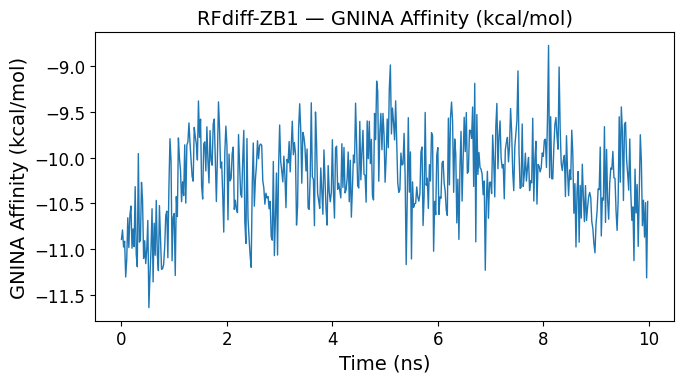

Guardado: ./figuras_md_gnina/gnina_affinity/RFdiff-ZB1_gnina_affinity.png


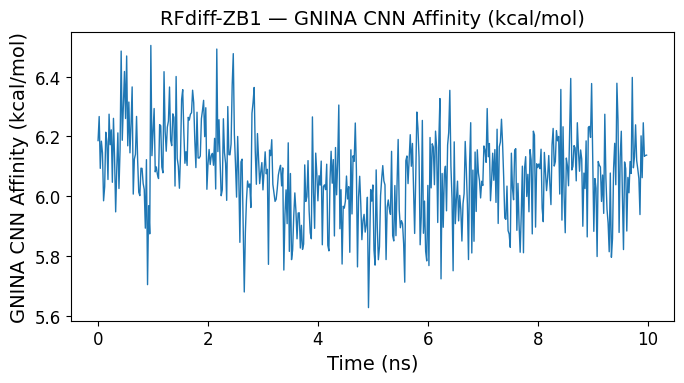

Guardado: ./figuras_md_gnina/gnina_cnnaffinity/RFdiff-ZB1_gnina_cnnaffinity.png


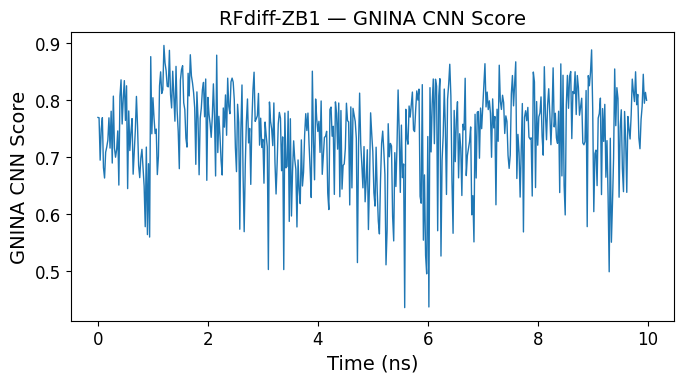

Guardado: ./figuras_md_gnina/gnina_cnnscore/RFdiff-ZB1_gnina_cnnscore.png


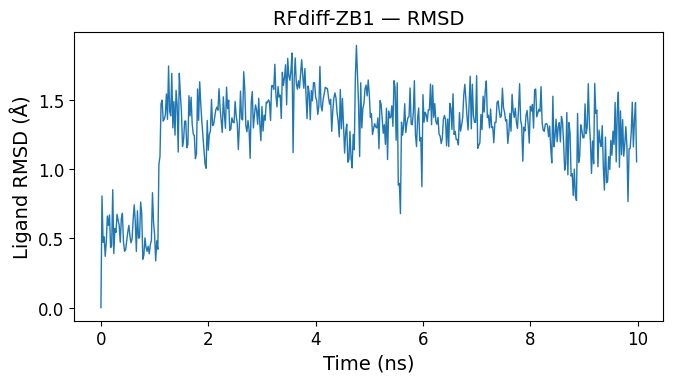

Guardado: ./figuras_md_gnina/ligand_rmsd/RFdiff-ZB1_ligand_rmsd.png


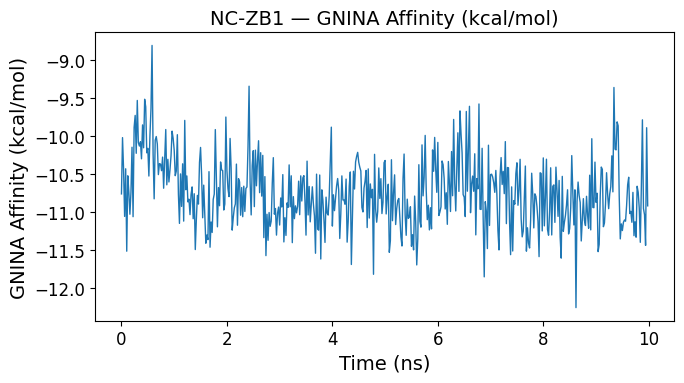

Guardado: ./figuras_md_gnina/gnina_affinity/NC-ZB1_gnina_affinity.png


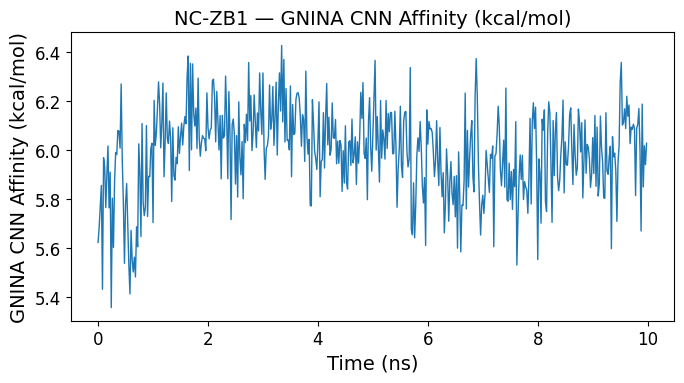

Guardado: ./figuras_md_gnina/gnina_cnnaffinity/NC-ZB1_gnina_cnnaffinity.png


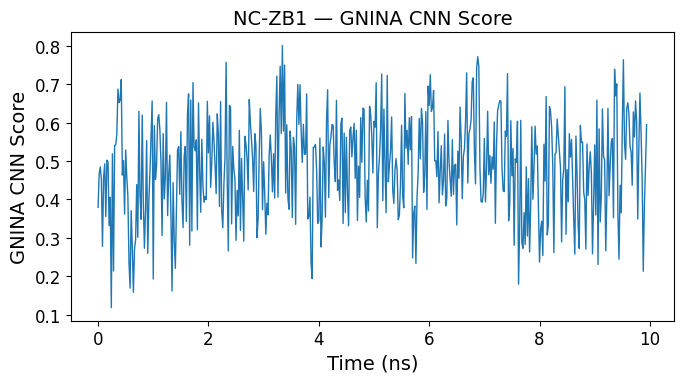

Guardado: ./figuras_md_gnina/gnina_cnnscore/NC-ZB1_gnina_cnnscore.png


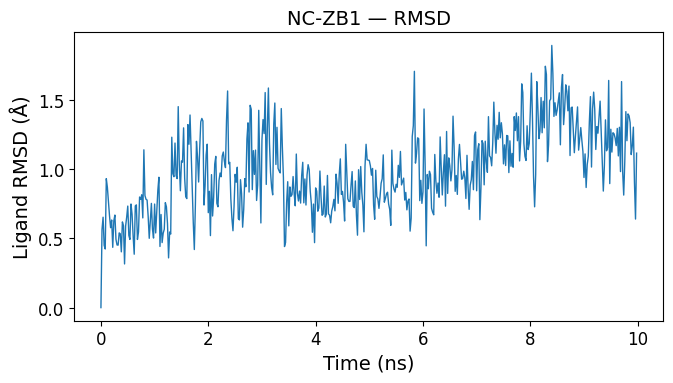

Guardado: ./figuras_md_gnina/ligand_rmsd/NC-ZB1_ligand_rmsd.png


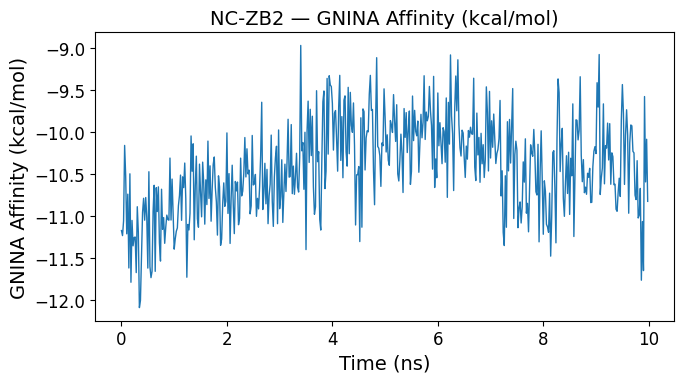

Guardado: ./figuras_md_gnina/gnina_affinity/NC-ZB2_gnina_affinity.png


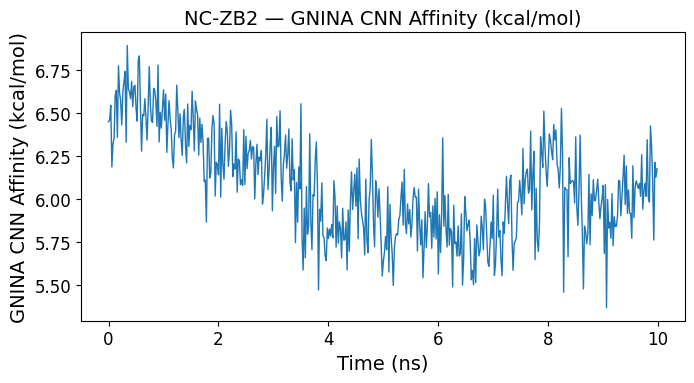

Guardado: ./figuras_md_gnina/gnina_cnnaffinity/NC-ZB2_gnina_cnnaffinity.png


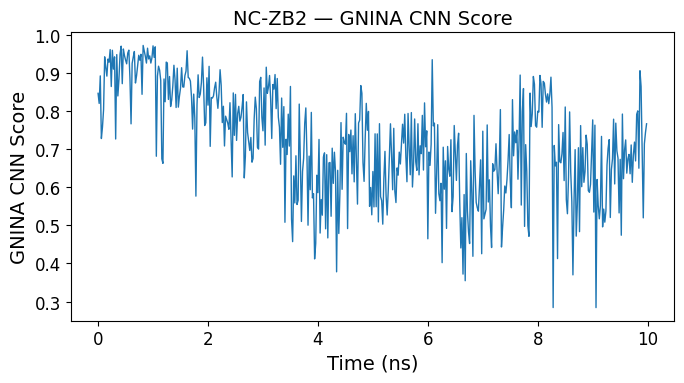

Guardado: ./figuras_md_gnina/gnina_cnnscore/NC-ZB2_gnina_cnnscore.png


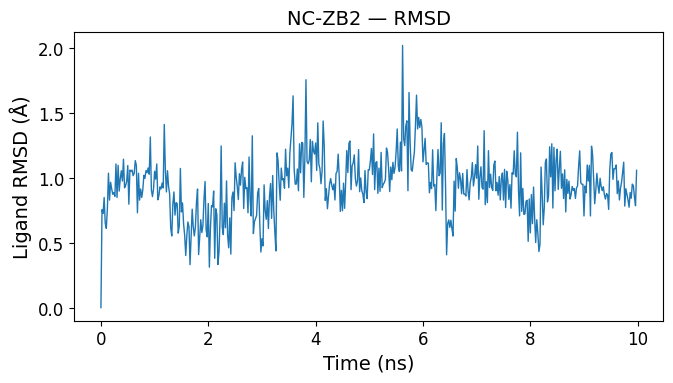

Guardado: ./figuras_md_gnina/ligand_rmsd/NC-ZB2_ligand_rmsd.png


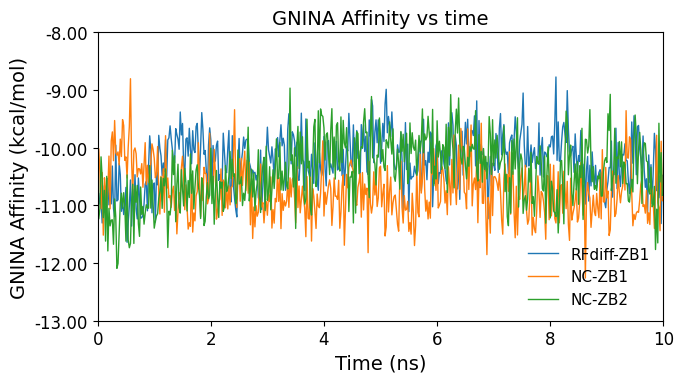

Guardado: ./figuras_md_gnina/gnina_affinity_vs_time.png


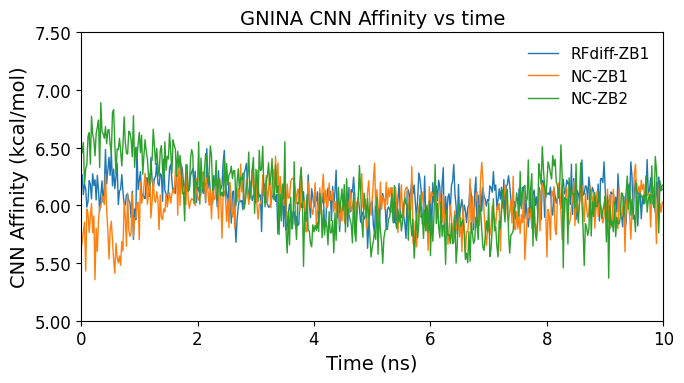

Guardado: ./figuras_md_gnina/gnina_cnn_affinity_vs_time.png


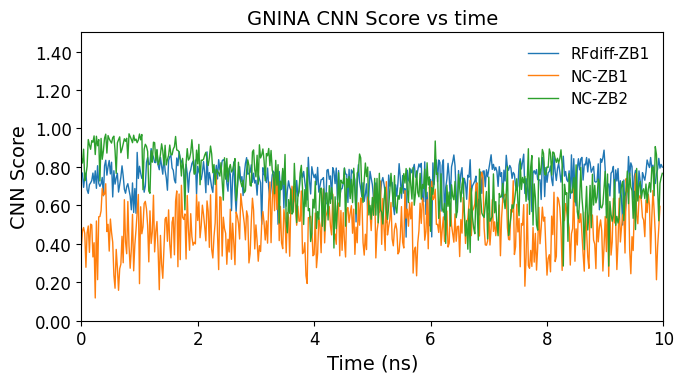

Guardado: ./figuras_md_gnina/gnina_cnn_score_vs_time.png


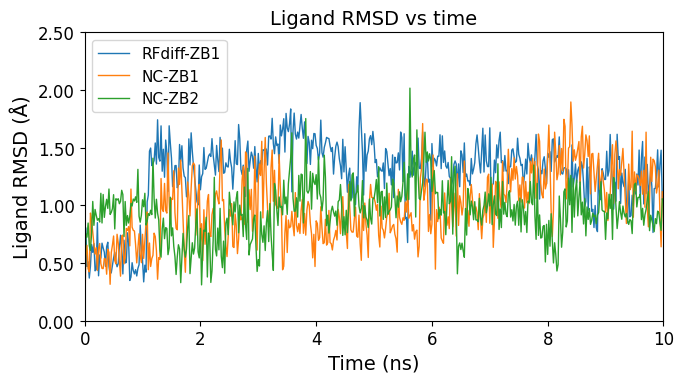

Guardado: ./figuras_md_gnina/ligand_rmsd_vs_time.png


In [27]:
%matplotlib inline

#!/usr/bin/env python3
"""
Script para generar gráficos publicables a partir de:
- GNINA_affinity.csv
- GNINA_CNNaffinity.csv
- GNINA_CNNscore.csv
- ligand_rmsd_noFit_frame0.csv

para varias proteínas/diseños que hayan pasado por el mismo pipeline.
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter


# ==========================
# 1. CONFIGURACIÓN DEL USUARIO
# ==========================

# Lista de proteínas/diseños.
# Ajusta 'dir' a la carpeta donde están los CSV de cada proteína.
# 'label' será el nombre que aparecerá en las leyendas.
proteins = [
    {
        "label": "RFdiff-ZB1",
        "dir": "/content/drive/MyDrive/Biosensores/Manuscript/21_4"
    },
    {
        "label": "NC-ZB1",
        "dir": "/content/drive/MyDrive/Biosensores/Manuscript/4HEL"
    },
    {
        "label": "NC-ZB2",
        "dir": "/content/drive/MyDrive/Biosensores/Manuscript/NTF2"
    },
]

# Límites opcionales de ejes (pon None si quieres que sea automático)
X_MIN_NS = 0
X_MAX_NS = 10   # por ejemplo, 20 ns si tu simulación dura eso

RMSD_Y_MIN = 0.0
RMSD_Y_MAX = 2.5

AFF_Y_MIN = -13.0
AFF_Y_MAX = -8.0

CNNAFF_Y_MIN = 5.0
CNNAFF_Y_MAX = 7.5

CNNSCORE_Y_MIN = 0.0
CNNSCORE_Y_MAX = 1.5

TITLE_AFFINITY    = "GNINA Affinity vs time"
TITLE_CNNAFFINITY = "GNINA CNN Affinity vs time"
TITLE_CNNSCORE    = "GNINA CNN Score vs time"
TITLE_RMSD        = "Ligand RMSD vs time"

# Nombres de los archivos CSV (tal como los genera tu pipeline)
GNINA_AFFINITY_FILE      = "GNINA_affinity.csv"
GNINA_CNNAFFINITY_FILE   = "GNINA_CNNaffinity.csv"
GNINA_CNNSCORE_FILE      = "GNINA_CNNscore.csv"
LIGAND_RMSD_FILE         = "ligand_rmsd_noFit_frame0.csv"

# Conversión de frame a tiempo:
# según tu 09_prod.py: Stride_Time_ns = 2, Frames_per_stride = 100 -> 0.02 ns/frame
USE_TIME_AXIS = True           # Si False, se grafica vs Frame
TIME_PER_FRAME_NS = 0.02       # ajusta si cambiaste parámetros en MD

# Estilo de los gráficos (puedes cambiar a 'seaborn-whitegrid', etc. si lo tienes instalado)
plt.style.use("default")
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 11,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# Carpeta de salida para las figuras
OUTPUT_DIR = "./figuras_md_gnina"
os.makedirs(OUTPUT_DIR, exist_ok=True)


# ==========================
# 2. FUNCIONES AUXILIARES
# ==========================

def load_gnina_csv(path):
    """
    Carga un CSV de GNINA (affinity, CNNaffinity, CNNscore) y devuelve
    la SERIE de la columna de valores (no el índice).
    En tus archivos, la columna útil es la segunda (nombre '0').
    """
    import pandas as pd

    df = pd.read_csv(path)

    # Intentar convertir todas las columnas a numérico donde se pueda
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Columnas numéricas
    num_cols = [c for c in df.columns if df[c].dtype.kind in "fi"]

    if not num_cols:
        raise ValueError(f"No se encontraron columnas numéricas en {path}")

    # Excluir explícitamente la(s) columna(s) 'Unnamed: ...' (índice viejo)
    value_cols = [c for c in num_cols if not c.lower().startswith("unnamed")]

    # Si existe al menos una columna numérica que no sea 'Unnamed', usamos esa
    if value_cols:
        col_to_use = value_cols[0]
    else:
        # Fallback: si todo es 'Unnamed', usamos la última numérica
        col_to_use = num_cols[-1]

    series = df[col_to_use].dropna().reset_index(drop=True)
    return series

def load_rmsd_csv(path):
    """
    Carga el CSV ligand_rmsd_noFit_frame0.csv.
    Asume columnas: 'Frame' y 'RMSD_noFit_frame0'.
    """
    df = pd.read_csv(path)
    if "Frame" not in df.columns or "RMSD_noFit_frame0" not in df.columns:
        raise ValueError(f"Se esperaban columnas 'Frame' y 'RMSD_noFit_frame0' en {path}")
    return df["Frame"], df["RMSD_noFit_frame0"]


def frame_to_time(frame_series):
    """
    Convierte una Serie de frames a tiempo en ns.
    """
    return frame_series * TIME_PER_FRAME_NS


# ==========================
# 3. CARGA DE DATOS
# ==========================

data = []
for p in proteins:
    label = p["label"]
    base = p["dir"]

    aff_path     = os.path.join(base, GNINA_AFFINITY_FILE)
    cnnaff_path  = os.path.join(base, GNINA_CNNAFFINITY_FILE)
    cnnscore_path= os.path.join(base, GNINA_CNNSCORE_FILE)
    rmsd_path    = os.path.join(base, LIGAND_RMSD_FILE)

    affinity     = load_gnina_csv(aff_path)
    cnnaffinity  = load_gnina_csv(cnnaff_path)
    cnnscore     = load_gnina_csv(cnnscore_path)
    frames, rmsd = load_rmsd_csv(rmsd_path)

    if USE_TIME_AXIS:
        x_rmsd = frame_to_time(frames)
        x_gnina = frame_to_time(pd.Series(range(len(affinity))))
        x_label = "Time (ns)"
    else:
        x_rmsd = frames
        x_gnina = pd.Series(range(len(affinity)))
        x_label = "Frame"

    data.append({
        "label": label,
        "x_gnina": x_gnina,
        "affinity": affinity,
        "cnnaffinity": cnnaffinity,
        "cnnscore": cnnscore,
        "x_rmsd": x_rmsd,
        "rmsd": rmsd,
    })

# ==========================
# NUEVO BLOQUE — 12 FIGURAS INDIVIDUALES
# ==========================

metrics = {
    "affinity":      ("GNINA Affinity (kcal/mol)", "gnina_affinity"),
    "cnnaffinity":   ("GNINA CNN Affinity (kcal/mol)", "gnina_cnnaffinity"),
    "cnnscore":      ("GNINA CNN Score", "gnina_cnnscore"),
    "rmsd":          ("Ligand RMSD (Å)", "ligand_rmsd")
}

# Crear carpetas para cada métrica
for _, (_, folder) in metrics.items():
    os.makedirs(os.path.join(OUTPUT_DIR, folder), exist_ok=True)

for d in data:
    name = d["label"]

    for key, (ylabel, folder) in metrics.items():
        plt.figure(figsize=(7,4))

        if key == "rmsd":
            x = d["x_rmsd"]
            y = d["rmsd"]
            title = f"{name} — RMSD"
        else:
            y = d[key]
            x = d["x_gnina"].iloc[:len(y)]
            title = f"{name} — {ylabel}"

        plt.plot(x, y, linewidth=1)
        plt.xlabel(x_label)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.tight_layout()

        # Mostrar en la salida del notebook
        plt.show()

        # Seguir guardando en archivo si quieres
        out_path = os.path.join(
            OUTPUT_DIR,
            folder,
            f"{name}_{folder}.png"
        )
        plt.savefig(out_path, dpi=300)
        plt.close()
        print("Guardado:", out_path)

# ==========================
# 4. GRÁFICOS COMPARATIVOS
# ==========================

def plot_metric(metric_key, ylabel, title, filename,
                y_min=None, y_max=None):
    plt.figure(figsize=(7, 4))
    all_x_max = []

    for d in data:
        y = d[metric_key]
        x = d["x_gnina"].iloc[:len(y)]
        all_x_max.append(x.max())
        plt.plot(x, y, linewidth=1, label=d["label"])

    plt.xlabel(x_label)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(frameon=False)

 # ==== AJUSTES DE EJES ====
    max_x = max(all_x_max)

    # X: si usas tiempo
    plt.xlim(X_MIN_NS, X_MAX_NS if X_MAX_NS is not None else max_x)

    # Y: si pasas límites
    if (y_min is not None) and (y_max is not None):
        plt.ylim(y_min, y_max)

    # ticks en X cada 2 ns (ajusta a gusto)
    plt.xticks(np.arange(X_MIN_NS, (X_MAX_NS or max_x) + 0.5, 2.0))

    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.tight_layout()
    plt.show()  # ver en notebook

    out_path = os.path.join(OUTPUT_DIR, filename)
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"Guardado: {out_path}")

def plot_rmsd():
    plt.figure(figsize=(7, 4))
    all_x_max = []
    for d in data:
        all_x_max.append(d["x_rmsd"].max())
        plt.plot(d["x_rmsd"], d["rmsd"], marker="", linewidth=1, label=d["label"])
    max_x = max(all_x_max)
    plt.xlabel(x_label)
    plt.ylabel("Ligand RMSD (Å)")
    plt.title(TITLE_RMSD)
    plt.legend(loc="best")

    # Límites en X e Y
    plt.xlim(X_MIN_NS, X_MAX_NS if X_MAX_NS is not None else max_x)
    plt.ylim(RMSD_Y_MIN, RMSD_Y_MAX)

    # Ticks en X cada 2 ns (ajusta a gusto)
    plt.xticks(np.arange(X_MIN_NS, (X_MAX_NS or max_x) + 0.5, 2.0))
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.tight_layout()
    plt.show()

    out_path = os.path.join(OUTPUT_DIR, "ligand_rmsd_vs_time.png")
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"Guardado: {out_path}")


# ---- Affinity vs tiempo ----
plot_metric(
    metric_key="affinity",
    ylabel="GNINA Affinity (kcal/mol)",
    title=TITLE_AFFINITY,
    filename="gnina_affinity_vs_time.png",
    y_min=AFF_Y_MIN,
    y_max=AFF_Y_MAX
)
# ---- CNNaffinity vs tiempo ----
plot_metric(
    metric_key="cnnaffinity",
    ylabel="CNN Affinity (kcal/mol)",
    title=TITLE_CNNAFFINITY,
    filename="gnina_cnn_affinity_vs_time.png",
    y_min=CNNAFF_Y_MIN,
    y_max=CNNAFF_Y_MAX,
)

# ---- CNNscore vs tiempo ----
plot_metric(
    metric_key="cnnscore",
    ylabel="CNN Score",
    title=TITLE_CNNSCORE,
    filename="gnina_cnn_score_vs_time.png",
    y_min=CNNSCORE_Y_MIN,
    y_max=CNNSCORE_Y_MAX
)
# ---- RMSD del ligando vs tiempo ----
plot_rmsd()


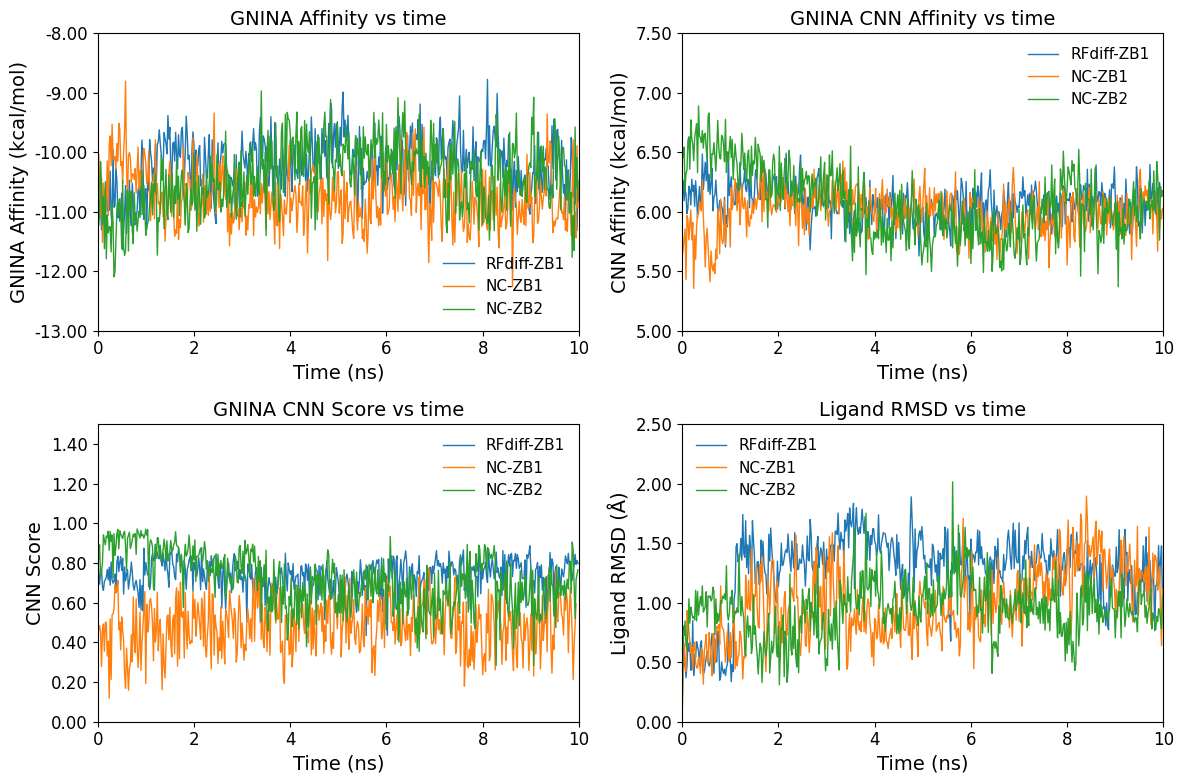

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

# 2×2 grid: Affinity, CNN Affinity, CNN Score, RMSD
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# ==========================
# Panel (0,0): GNINA Affinity
# ==========================
ax = axs[0, 0]
all_x_max = []
for d in data:
    y = d["affinity"]
    x = d["x_gnina"].iloc[:len(y)]
    all_x_max.append(x.max())
    ax.plot(x, y, linewidth=1, label=d["label"])

max_x = max(all_x_max)
ax.set_xlabel(x_label)
ax.set_ylabel("GNINA Affinity (kcal/mol)")
ax.set_title(TITLE_AFFINITY)
ax.set_xlim(X_MIN_NS, X_MAX_NS if X_MAX_NS is not None else max_x)
ax.set_ylim(AFF_Y_MIN, AFF_Y_MAX)
ax.set_xticks(np.arange(X_MIN_NS, (X_MAX_NS or max_x) + 0.5, 2.0))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.legend(loc="best", frameon=False)

# ==========================
# Panel (0,1): CNN Affinity
# ==========================
ax = axs[0, 1]
all_x_max = []
for d in data:
    y = d["cnnaffinity"]
    x = d["x_gnina"].iloc[:len(y)]
    all_x_max.append(x.max())
    ax.plot(x, y, linewidth=1, label=d["label"])

max_x = max(all_x_max)
ax.set_xlabel(x_label)
ax.set_ylabel("CNN Affinity (kcal/mol)")
ax.set_title(TITLE_CNNAFFINITY)
ax.set_xlim(X_MIN_NS, X_MAX_NS if X_MAX_NS is not None else max_x)
ax.set_ylim(CNNAFF_Y_MIN, CNNAFF_Y_MAX)
ax.set_xticks(np.arange(X_MIN_NS, (X_MAX_NS or max_x) + 0.5, 2.0))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.legend(loc="best", frameon=False)

# ==========================
# Panel (1,0): CNN Score
# ==========================
ax = axs[1, 0]
all_x_max = []
for d in data:
    y = d["cnnscore"]
    x = d["x_gnina"].iloc[:len(y)]
    all_x_max.append(x.max())
    ax.plot(x, y, linewidth=1, label=d["label"])

max_x = max(all_x_max)
ax.set_xlabel(x_label)
ax.set_ylabel("CNN Score")
ax.set_title(TITLE_CNNSCORE)
ax.set_xlim(X_MIN_NS, X_MAX_NS if X_MAX_NS is not None else max_x)
ax.set_ylim(CNNSCORE_Y_MIN, CNNSCORE_Y_MAX)
ax.set_xticks(np.arange(X_MIN_NS, (X_MAX_NS or max_x) + 0.5, 2.0))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.legend(loc="best", frameon=False)

# ==========================
# Panel (1,1): Ligand RMSD
# ==========================
ax = axs[1, 1]
all_x_max = []
for d in data:
    x = d["x_rmsd"]
    y = d["rmsd"]
    all_x_max.append(x.max())
    ax.plot(x, y, linewidth=1, label=d["label"])

max_x = max(all_x_max)
ax.set_xlabel(x_label)
ax.set_ylabel("Ligand RMSD (Å)")
ax.set_title(TITLE_RMSD)
ax.set_xlim(X_MIN_NS, X_MAX_NS if X_MAX_NS is not None else max_x)
ax.set_ylim(RMSD_Y_MIN, RMSD_Y_MAX)
ax.set_xticks(np.arange(X_MIN_NS, (X_MAX_NS or max_x) + 0.5, 2.0))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.legend(loc="best", frameon=False)

# Ajuste general
plt.tight_layout()
plt.show()

# Si quieres guardar la figura completa, descomenta:
# fig.savefig(os.path.join(OUTPUT_DIR, "4panel_md_gnina.png"), dpi=300)


# GNINA scores de prots naturales

In [ ]:


import os
import requests
from Bio.PDB import PDBParser, PDBIO, Select

class ProteinOnlySelect(Select):
    """Selecciona solo residuos estándar de proteína (sin ligandos ni aguas)."""
    def accept_residue(self, residue):
        # residue.id[0] == ' ' → residuo estándar (no HETATM, no water)
        return residue.id[0] == ' '

def download_and_prepare_receptor(pdb_id, output_name="receptor.pdb"):
    """
    Descarga una estructura del PDB por ID, extrae solo la proteína
    y guarda un archivo listo para docking como `output_name`.
    """
    pdb_id = pdb_id.upper()
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    raw_pdb = f"{pdb_id}.pdb"
    clean_pdb = output_name

    print(f"Descargando {pdb_id} desde {url} ...")
    r = requests.get(url)
    if r.status_code != 200:
        raise ValueError(f"No se pudo descargar {pdb_id}: status {r.status_code}")

    with open(raw_pdb, "w") as f:
        f.write(r.text)
    print(f"Guardado PDB original como: {raw_pdb}")

    # Parsear y limpiar (solo proteína)
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, raw_pdb)

    io = PDBIO()
    io.set_structure(structure)
    io.save(clean_pdb, select=ProteinOnlySelect())
    print(f"Receptor limpio (solo proteína) guardado como: {clean_pdb}")

    return os.path.abspath(clean_pdb)


In [ ]:
# ============================================
#   INSTALL ONLY WHAT IS NEEDED FOR GNINA
# ============================================

import subprocess, os, tarfile, sys

# Utilities that ARE useful:
# - py3Dmol: visualization
# - biopython: manejo de PDBs
commands = [
    "pip install py3Dmol biopython",
]

print("Installing minimal dependencies...")
for cmd in commands:
    print(f"→ {cmd}")
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("  ⚠ Error:", result.stderr[:250])
    else:
        print("  ✓ OK")

# ============================================
#   DOWNLOAD GNINA (YOU MUST PROVIDE THE CORRECT URL)
# ============================================

# *** IMPORTANT ***
# Reemplaza esta URL con la URL EXACTA del binario GNINA para Linux x86_64
# obtenida desde GitHub releases.
GNINA_URL = "https://github.com/gnina/gnina/releases/download/v1.0.3/gnina"  # <-- EDIT THIS IF NEEDED

print("\nDownloading GNINA from:")
print(GNINA_URL)

res = subprocess.run(f"wget -O gnina {GNINA_URL}", shell=True, capture_output=True, text=True)
if res.returncode != 0:
    print("⚠ ERROR downloading GNINA:")
    print(res.stderr[:300])
else:
    print("✓ GNINA downloaded")

# Dar permisos de ejecución
subprocess.run("chmod +x gnina", shell=True)

# Test GNINA
print("\nTesting GNINA execution…")
test = subprocess.run("./gnina --version", shell=True, capture_output=True, text=True)
if test.returncode != 0:
    print("⚠ GNINA NOT WORKING:")
    print(test.stderr[:300])
else:
    print("GNINA version detected:")
    print(test.stdout)
    print("✓ GNINA installed correctly!")

print("\nDONE.")


Installing minimal dependencies...
→ pip install py3Dmol biopython
  ✓ OK

https://github.com/gnina/gnina/releases/download/v1.0.3/gnina
✓ GNINA downloaded

Testing GNINA execution…
GNINA version detected:
gnina  master:e9cb230+   Built Feb 11 2023.

✓ GNINA installed correctly!

DONE.


## 3WZM

In [ ]:
# Cambia este ID por el que quieras del Protein Data Bank
pdb_id = "3WZM"   # por ejemplo: "1A2B", "3CLN", etc.

receptor_path = download_and_prepare_receptor(pdb_id, output_name="receptor.pdb")
print("Receptor listo para docking en:", receptor_path)


Descargando 3WZM desde https://files.rcsb.org/download/3WZM.pdb ...
Guardado PDB original como: 3WZM.pdb
Receptor limpio (solo proteína) guardado como: receptor.pdb
Receptor listo para docking en: /content/receptor.pdb


In [ ]:
import subprocess
import os

# ==== CONFIGURACIÓN DEL USUARIO ====
receptor = "receptor.pdb"        # tu proteína
ligand   = "/content/drive/MyDrive/Biosensores/Manuscript/Nat_prots/3WZM/ligand_out.sdf"        # o ligand_out.sdf
output = f"score_gnina_{pdb_id}.sdf"

# Caja (campos OBLIGATORIOS para gnina)
center_x = -51.805 # cambia a tus coordenadas
center_y = -5.711
center_z = -16.789

size_x = 10
size_y = 10
size_z = 10
# ====================================

gnina_path = "./gnina"
if not os.path.exists(gnina_path) or not os.access(gnina_path, os.X_OK):
    print(f"Error: GNINA executable not found or not executable at '{gnina_path}'.")
    print("Please ensure GNINA is installed correctly by re-running the installation cell (Instalar GNINA).")
    raise FileNotFoundError(f"GNINA executable not found or not executable at '{gnina_path}'.")

cmd = [
    gnina_path,
    "-r", receptor,
    "-l", ligand,
    "--minimize",            # calcula affinity, CNNscore, CNNaffinity, RMSD
    "-o", output,
    "--center_x", str(center_x),
    "--center_y", str(center_y),
    "--center_z", str(center_z),
    "--size_x", str(size_x),
    "--size_y", str(size_y),
    "--size_z", str(size_z)
]

print("Ejecutando GNINA…\n")
result = subprocess.run(cmd, capture_output=True, text=True)

print("STDOUT:\n", result.stdout[:500])
print("\nArchivo generado:", output)

# Mostrar los scores directamente en la terminal:
with open(output) as f:
    sdf = f.read()

import re

fields = {
    "minimizedAffinity": r"> <minimizedAffinity>\s*([+-]?[0-9]*\.[0-9]+)",
    "CNNscore": r"> <CNNscore>\s*([0-9]*\.[0-9]+)",
    "CNNaffinity": r"> <CNNaffinity>\s*([0-9]*\.[0-9]+)",
    "minimizedRMSD": r"> <minimizedRMSD>\s*([0-9]*\.[0-9]+)"
}

print("\n=== SCORES OBTENIDOS ===")
for name, pattern in fields.items():
    m = re.search(pattern, sdf)
    if m:
        print(f"{name}: {m.group(1)}")
    else:
        print(f"{name}: no encontrado")

Ejecutando GNINA…

STDOUT:
               _             
             (_)            
   __ _ _ __  _ _ __   __ _ 
  / _` | '_ \| | '_ \ / _` |
 | (_| | | | | | | | | (_| |
  \__, |_| |_|_|_| |_|\__,_|
   __/ |                    
  |___/                     

gnina  master:e9cb230+   Built Feb 11 2023.
gnina is based on smina and AutoDock Vina.
Please cite appropriately.

Commandline: ./gnina -r receptor.pdb -l /content/drive/MyDrive/Biosensores/Manuscript/Nat_prots/3WZM/ligand_out.sdf --minimize -o score_gnina_3WZM.sdf -

Archivo generado: score_gnina_3WZM.sdf

=== SCORES OBTENIDOS ===
minimizedAffinity: -6.91943
CNNscore: 0.1095776781
CNNaffinity: 4.6170473099
minimizedRMSD: 4.81004


In [ ]:
import MDAnalysis as mda
import subprocess, os
import pandas as pd
from rdkit import Chem

# ========= CONFIGURACIÓN =========
complex_pdb = "3WZM.pdb"   # PDB cristalográfico proteína+ligando
lig_resname = "ZER"                   # cambia por el resname real del ligando (p.ej. "NAG", "INH", etc.)
minimization = "Yes"                  # "Yes" -> --minimize, "No" -> --score_only

workDir = os.getcwd()
pdb_dir = os.path.join(workDir, "PDBs_nat")
os.makedirs(pdb_dir, exist_ok=True)

output = workDir

# ========= SEPARAR PROTEÍNA Y LIGANDO =========
u = mda.Universe(complex_pdb)

prot = u.select_atoms("protein")
lig  = u.select_atoms(f"resname {lig_resname}")

if lig.n_atoms == 0:
    raise ValueError(f"No se encontraron átomos con resname {lig_resname} en {complex_pdb}")

protein_pdb = os.path.join(pdb_dir, "protein.pdb")
ligand_pdb  = os.path.join(pdb_dir, "ligand.pdb")

prot.write(protein_pdb)
lig.write(ligand_pdb)

print("Proteína guardada en:", protein_pdb)
print("Ligando guardado en:", ligand_pdb)

# ========= CORRER GNINA UNA VEZ =========
minimize_flag = "--minimize" if minimization == "Yes" else "--score_only"
score_sdf = os.path.join(output, f"score_gnina_{pdb_id}.sdf")

cmd = f"./gnina -r {protein_pdb} -l {ligand_pdb} {minimize_flag} -o {score_sdf}"
print("\nEjecutando GNINA:")
print(cmd)

res_run = subprocess.run(cmd, shell=True, capture_output=True, text=True)
print("STDOUT:\n", res_run.stdout[:400])
print("STDERR:\n", res_run.stderr[:400])

# ========= LEER SDF Y EXTRAER SCORES =========
suppl = Chem.SDMolSupplier(score_sdf, sanitize=True)
mol = suppl[0]

affinity     = float(mol.GetProp("minimizedAffinity"))
cnn_score    = float(mol.GetProp("CNNscore"))
cnn_affinity = float(mol.GetProp("CNNaffinity"))

print("\n=== SCORES OBTENIDOS (estructura cristalográfica) ===")
print("minimizedAffinity:", affinity)
print("CNNscore:", cnn_score)
print("CNNaffinity:", cnn_affinity)

# ========= GUARDAR EN CSV COMO EN EL PIPELINE 1–12 =========
pd.DataFrame([affinity]).to_csv(os.path.join(output, "GNINA_affinity.csv"), index=False, header=False)
pd.DataFrame([cnn_score]).to_csv(os.path.join(output, "GNINA_CNNscore.csv"), index=False, header=False)
pd.DataFrame([cnn_affinity]).to_csv(os.path.join(output, "GNINA_CNNaffinity.csv"), index=False, header=False)

print("\nCSV generados:")
print(" - GNINA_affinity.csv")
print(" - GNINA_CNNscore.csv")
print(" - GNINA_CNNaffinity.csv")


Proteína guardada en: /content/PDBs_nat/protein.pdb
Ligando guardado en: /content/PDBs_nat/ligand.pdb

Ejecutando GNINA:
./gnina -r /content/PDBs_nat/protein.pdb -l /content/PDBs_nat/ligand.pdb --minimize -o /content/score_gnina_3WZM.sdf
STDOUT:
               _             
             (_)            
   __ _ _ __  _ _ __   __ _ 
  / _` | '_ \| | '_ \ / _` |
 | (_| | | | | | | | | (_| |
  \__, |_| |_|_|_| |_|\__,_|
   __/ |                    
  |___/                     

gnina  master:e9cb230+   Built Feb 11 2023.
gnina is based on smina and AutoDock Vina.
Please cite appropriately.

Commandline: ./gnina -r /content/PDBs_nat/protein.pd
STDERR:
*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.


=== SCORES OBTENIDOS (estructura cristalográfica) ===
minimizedAffinity: -11.37569
CNNscore: 0.8978480101
CNNaffinity: 6.4921584129

CSV generados:
 - G

[00:35:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


## 5KRC

In [ ]:
# Cambia este ID por el que quieras del Protein Data Bank
pdb_id = "5KRC"   # por ejemplo: "1A2B", "3CLN", etc.

receptor_path = download_and_prepare_receptor(pdb_id, output_name="receptor.pdb")
print("Receptor listo para docking en:", receptor_path)


Descargando 5KRC desde https://files.rcsb.org/download/5KRC.pdb ...
Guardado PDB original como: 5KRC.pdb
Receptor limpio (solo proteína) guardado como: receptor.pdb
Receptor listo para docking en: /content/receptor.pdb


In [ ]:
import MDAnalysis as mda
import subprocess, os
import pandas as pd
from rdkit import Chem

# ========= CONFIGURACIÓN =========
complex_pdb = "5KRC.pdb"   # PDB cristalográfico proteína+ligando
lig_resname = "ZER"                   # cambia por el resname real del ligando (p.ej. "NAG", "INH", etc.)
minimization = "Yes"                  # "Yes" -> --minimize, "No" -> --score_only

workDir = os.getcwd()
pdb_dir = os.path.join(workDir, "PDBs_nat")
os.makedirs(pdb_dir, exist_ok=True)

output = workDir

# ========= SEPARAR PROTEÍNA Y LIGANDO =========
u = mda.Universe(complex_pdb)

prot = u.select_atoms("protein")
lig  = u.select_atoms(f"resname {lig_resname}")

if lig.n_atoms == 0:
    raise ValueError(f"No se encontraron átomos con resname {lig_resname} en {complex_pdb}")

protein_pdb = os.path.join(pdb_dir, "protein.pdb")
ligand_pdb  = os.path.join(pdb_dir, "ligand.pdb")

prot.write(protein_pdb)
lig.write(ligand_pdb)

print("Proteína guardada en:", protein_pdb)
print("Ligando guardado en:", ligand_pdb)

# ========= CORRER GNINA UNA VEZ =========
minimize_flag = "--minimize" if minimization == "Yes" else "--score_only"
score_sdf = os.path.join(output, f"score_gnina_{pdb_id}.sdf")

cmd = f"./gnina -r {protein_pdb} -l {ligand_pdb} {minimize_flag} -o {score_sdf}"
print("\nEjecutando GNINA:")
print(cmd)

res_run = subprocess.run(cmd, shell=True, capture_output=True, text=True)
print("STDOUT:\n", res_run.stdout[:400])
print("STDERR:\n", res_run.stderr[:400])

# ========= LEER SDF Y EXTRAER SCORES =========
suppl = Chem.SDMolSupplier(score_sdf, sanitize=True)
mol = suppl[0]

affinity     = float(mol.GetProp("minimizedAffinity"))
cnn_score    = float(mol.GetProp("CNNscore"))
cnn_affinity = float(mol.GetProp("CNNaffinity"))

print("\n=== SCORES OBTENIDOS (estructura cristalográfica) ===")
print("minimizedAffinity:", affinity)
print("CNNscore:", cnn_score)
print("CNNaffinity:", cnn_affinity)

# ========= GUARDAR EN CSV COMO EN EL PIPELINE 1–12 =========
pd.DataFrame([affinity]).to_csv(os.path.join(output, "GNINA_affinity.csv"), index=False, header=False)
pd.DataFrame([cnn_score]).to_csv(os.path.join(output, "GNINA_CNNscore.csv"), index=False, header=False)
pd.DataFrame([cnn_affinity]).to_csv(os.path.join(output, "GNINA_CNNaffinity.csv"), index=False, header=False)

print("\nCSV generados:")
print(" - GNINA_affinity.csv")
print(" - GNINA_CNNscore.csv")
print(" - GNINA_CNNaffinity.csv")


/usr/local/lib/python3.12/dist-packages/MDAnalysis/coordinates/PDB.py:1282: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn(


Proteína guardada en: /content/PDBs_nat/protein.pdb
Ligando guardado en: /content/PDBs_nat/ligand.pdb

Ejecutando GNINA:
./gnina -r /content/PDBs_nat/protein.pdb -l /content/PDBs_nat/ligand.pdb --minimize -o /content/score_gnina_5KRC.sdf
STDOUT:
               _             
             (_)            
   __ _ _ __  _ _ __   __ _ 
  / _` | '_ \| | '_ \ / _` |
 | (_| | | | | | | | | (_| |
  \__, |_| |_|_|_| |_|\__,_|
   __/ |                    
  |___/                     

gnina  master:e9cb230+   Built Feb 11 2023.
gnina is based on smina and AutoDock Vina.
Please cite appropriately.

Commandline: ./gnina -r /content/PDBs_nat/protein.pd
STDERR:
*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.


=== SCORES OBTENIDOS (estructura cristalográfica) ===
minimizedAffinity: -11.58601
CNNscore: 0.9088424444
CNNaffinity: 7.4792380333

CSV generados:
 - G

[00:40:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


## 4HEL

In [ ]:
# Cambia este ID por el que quieras del Protein Data Bank
pdb_id = "4HEL"   # por ejemplo: "1A2B", "3CLN", etc.

receptor_path = download_and_prepare_receptor(pdb_id, output_name="receptor.pdb")
print("Receptor listo para docking en:", receptor_path)


Descargando 4HEL desde https://files.rcsb.org/download/4HEL.pdb ...
Guardado PDB original como: 4HEL.pdb
Receptor limpio (solo proteína) guardado como: receptor.pdb
Receptor listo para docking en: /content/receptor.pdb


In [ ]:
import MDAnalysis as mda
import subprocess, os
import pandas as pd
from rdkit import Chem

# ========= CONFIGURACIÓN =========
complex_pdb = "prot_lig_prod_nw.pdb"   # PDB cristalográfico proteína+ligando
lig_resname = "UNK"                   # cambia por el resname real del ligando (p.ej. "NAG", "INH", etc.)
minimization = "Yes"                  # "Yes" -> --minimize, "No" -> --score_only

workDir = os.getcwd()
pdb_dir = os.path.join(workDir, "PDBs_nat")
os.makedirs(pdb_dir, exist_ok=True)

output = workDir

# ========= SEPARAR PROTEÍNA Y LIGANDO =========
u = mda.Universe(complex_pdb)

prot = u.select_atoms("protein")
lig  = u.select_atoms(f"resname {lig_resname}")

if lig.n_atoms == 0:
    raise ValueError(f"No se encontraron átomos con resname {lig_resname} en {complex_pdb}")

protein_pdb = os.path.join(pdb_dir, "protein.pdb")
ligand_pdb  = os.path.join(pdb_dir, "ligand.pdb")

prot.write(protein_pdb)
lig.write(ligand_pdb)

print("Proteína guardada en:", protein_pdb)
print("Ligando guardado en:", ligand_pdb)

# ========= CORRER GNINA UNA VEZ =========
minimize_flag = "--minimize" if minimization == "Yes" else "--score_only"
score_sdf = os.path.join(output, f"score_gnina_{complex_pdb}.sdf")

cmd = f"./gnina -r {protein_pdb} -l {ligand_pdb} {minimize_flag} -o {score_sdf}"
print("\nEjecutando GNINA:")
print(cmd)

res_run = subprocess.run(cmd, shell=True, capture_output=True, text=True)
print("STDOUT:\n", res_run.stdout[:400])
print("STDERR:\n", res_run.stderr[:400])

# ========= LEER SDF Y EXTRAER SCORES =========
suppl = Chem.SDMolSupplier(score_sdf, sanitize=True)
mol = suppl[0]

affinity     = float(mol.GetProp("minimizedAffinity"))
cnn_score    = float(mol.GetProp("CNNscore"))
cnn_affinity = float(mol.GetProp("CNNaffinity"))

print("\n=== SCORES OBTENIDOS (estructura cristalográfica) ===")
print("minimizedAffinity:", affinity)
print("CNNscore:", cnn_score)
print("CNNaffinity:", cnn_affinity)

# ========= GUARDAR EN CSV COMO EN EL PIPELINE 1–12 =========
pd.DataFrame([affinity]).to_csv(os.path.join(output, "GNINA_affinity.csv"), index=False, header=False)
pd.DataFrame([cnn_score]).to_csv(os.path.join(output, "GNINA_CNNscore.csv"), index=False, header=False)
pd.DataFrame([cnn_affinity]).to_csv(os.path.join(output, "GNINA_CNNaffinity.csv"), index=False, header=False)

print("\nCSV generados:")
print(" - GNINA_affinity.csv")
print(" - GNINA_CNNscore.csv")
print(" - GNINA_CNNaffinity.csv")


Proteína guardada en: /content/PDBs_nat/protein.pdb
Ligando guardado en: /content/PDBs_nat/ligand.pdb

Ejecutando GNINA:
./gnina -r /content/PDBs_nat/protein.pdb -l /content/PDBs_nat/ligand.pdb --minimize -o /content/score_gnina_prot_lig_prod_nw.pdb.sdf
STDOUT:
               _             
             (_)            
   __ _ _ __  _ _ __   __ _ 
  / _` | '_ \| | '_ \ / _` |
 | (_| | | | | | | | | (_| |
  \__, |_| |_|_|_| |_|\__,_|
   __/ |                    
  |___/                     

gnina  master:e9cb230+   Built Feb 11 2023.
gnina is based on smina and AutoDock Vina.
Please cite appropriately.

Commandline: ./gnina -r /content/PDBs_nat/protein.pd
STDERR:
*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.


=== SCORES OBTENIDOS (estructura cristalográfica) ===
minimizedAffinity: -10.89629
CNNscore: 0.7684300542
CNNaffinity: 6.1856088638

CSV

[00:57:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


# 5Z97

In [ ]:
# Cambia este ID por el que quieras del Protein Data Bank
pdb_id = "5Z97"   # por ejemplo: "1A2B", "3CLN", etc.

receptor_path = download_and_prepare_receptor(pdb_id, output_name="receptor.pdb")
print("Receptor listo para docking en:", receptor_path)


Descargando 5Z97 desde https://files.rcsb.org/download/5Z97.pdb ...
Guardado PDB original como: 5Z97.pdb
Receptor limpio (solo proteína) guardado como: receptor.pdb
Receptor listo para docking en: /content/receptor.pdb


In [ ]:
import MDAnalysis as mda
import subprocess, os
import pandas as pd
from rdkit import Chem

# ========= CONFIGURACIÓN =========
complex_pdb = "5Z97.pdb"   # PDB cristalográfico proteína+ligando
lig_resname = "ZER"                   # cambia por el resname real del ligando (p.ej. "NAG", "INH", etc.)
minimization = "Yes"                  # "Yes" -> --minimize, "No" -> --score_only

workDir = os.getcwd()
pdb_dir = os.path.join(workDir, "PDBs_nat")
os.makedirs(pdb_dir, exist_ok=True)

output = workDir

# ========= SEPARAR PROTEÍNA Y LIGANDO =========
u = mda.Universe(complex_pdb)

prot = u.select_atoms("protein")
lig  = u.select_atoms(f"resname {lig_resname}")

if lig.n_atoms == 0:
    raise ValueError(f"No se encontraron átomos con resname {lig_resname} en {complex_pdb}")

protein_pdb = os.path.join(pdb_dir, "protein.pdb")
ligand_pdb  = os.path.join(pdb_dir, "ligand.pdb")

prot.write(protein_pdb)
lig.write(ligand_pdb)

print("Proteína guardada en:", protein_pdb)
print("Ligando guardado en:", ligand_pdb)

# ========= CORRER GNINA UNA VEZ =========
minimize_flag = "--minimize" if minimization == "Yes" else "--score_only"
score_sdf = os.path.join(output, f"score_gnina_{pdb_id}.sdf")

cmd = f"./gnina -r {protein_pdb} -l {ligand_pdb} {minimize_flag} -o {score_sdf}"
print("\nEjecutando GNINA:")
print(cmd)

res_run = subprocess.run(cmd, shell=True, capture_output=True, text=True)
print("STDOUT:\n", res_run.stdout[:400])
print("STDERR:\n", res_run.stderr[:400])

# ========= LEER SDF Y EXTRAER SCORES =========
suppl = Chem.SDMolSupplier(score_sdf, sanitize=True)
mol = suppl[0]

affinity     = float(mol.GetProp("minimizedAffinity"))
cnn_score    = float(mol.GetProp("CNNscore"))
cnn_affinity = float(mol.GetProp("CNNaffinity"))

print("\n=== SCORES OBTENIDOS (estructura cristalográfica) ===")
print("minimizedAffinity:", affinity)
print("CNNscore:", cnn_score)
print("CNNaffinity:", cnn_affinity)

# ========= GUARDAR EN CSV COMO EN EL PIPELINE 1–12 =========
pd.DataFrame([affinity]).to_csv(os.path.join(output, "GNINA_affinity.csv"), index=False, header=False)
pd.DataFrame([cnn_score]).to_csv(os.path.join(output, "GNINA_CNNscore.csv"), index=False, header=False)
pd.DataFrame([cnn_affinity]).to_csv(os.path.join(output, "GNINA_CNNaffinity.csv"), index=False, header=False)

print("\nCSV generados:")
print(" - GNINA_affinity.csv")
print(" - GNINA_CNNscore.csv")
print(" - GNINA_CNNaffinity.csv")


/usr/local/lib/python3.12/dist-packages/MDAnalysis/coordinates/PDB.py:1282: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn(


Proteína guardada en: /content/PDBs_nat/protein.pdb
Ligando guardado en: /content/PDBs_nat/ligand.pdb

Ejecutando GNINA:
./gnina -r /content/PDBs_nat/protein.pdb -l /content/PDBs_nat/ligand.pdb --minimize -o /content/score_gnina_5Z97.sdf
STDOUT:
               _             
             (_)            
   __ _ _ __  _ _ __   __ _ 
  / _` | '_ \| | '_ \ / _` |
 | (_| | | | | | | | | (_| |
  \__, |_| |_|_|_| |_|\__,_|
   __/ |                    
  |___/                     

gnina  master:e9cb230+   Built Feb 11 2023.
gnina is based on smina and AutoDock Vina.
Please cite appropriately.

Commandline: ./gnina -r /content/PDBs_nat/protein.pd
STDERR:
*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.


=== SCORES OBTENIDOS (estructura cristalográfica) ===
minimizedAffinity: -11.56589
CNNscore: 0.9312981963
CNNaffinity: 6.6474852562

CSV generados:
 - G

[00:47:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


# 5XO8

In [ ]:
# Cambia este ID por el que quieras del Protein Data Bank
pdb_id = "5XO8"   # por ejemplo: "1A2B", "3CLN", etc.

receptor_path = download_and_prepare_receptor(pdb_id, output_name="receptor.pdb")
print("Receptor listo para docking en:", receptor_path)


Descargando 5XO8 desde https://files.rcsb.org/download/5XO8.pdb ...
Guardado PDB original como: 5XO8.pdb
Receptor limpio (solo proteína) guardado como: receptor.pdb
Receptor listo para docking en: /content/receptor.pdb


In [ ]:
import MDAnalysis as mda
import subprocess, os
import pandas as pd
from rdkit import Chem

# ========= CONFIGURACIÓN =========
complex_pdb = "5XO8.pdb"   # PDB cristalográfico proteína+ligando
lig_resname = "ZER"                   # cambia por el resname real del ligando (p.ej. "NAG", "INH", etc.)
minimization = "Yes"                  # "Yes" -> --minimize, "No" -> --score_only

workDir = os.getcwd()
pdb_dir = os.path.join(workDir, "PDBs_nat")
os.makedirs(pdb_dir, exist_ok=True)

output = workDir

# ========= SEPARAR PROTEÍNA Y LIGANDO =========
u = mda.Universe(complex_pdb)

prot = u.select_atoms("protein")
lig  = u.select_atoms(f"resname {lig_resname}")

if lig.n_atoms == 0:
    raise ValueError(f"No se encontraron átomos con resname {lig_resname} en {complex_pdb}")

protein_pdb = os.path.join(pdb_dir, "protein.pdb")
ligand_pdb  = os.path.join(pdb_dir, "ligand.pdb")

prot.write(protein_pdb)
lig.write(ligand_pdb)

print("Proteína guardada en:", protein_pdb)
print("Ligando guardado en:", ligand_pdb)

# ========= CORRER GNINA UNA VEZ =========
minimize_flag = "--minimize" if minimization == "Yes" else "--score_only"
score_sdf = os.path.join(output, f"score_gnina_{pdb_id}.sdf")

cmd = f"./gnina -r {protein_pdb} -l {ligand_pdb} {minimize_flag} -o {score_sdf}"
print("\nEjecutando GNINA:")
print(cmd)

res_run = subprocess.run(cmd, shell=True, capture_output=True, text=True)
print("STDOUT:\n", res_run.stdout[:400])
print("STDERR:\n", res_run.stderr[:400])

# ========= LEER SDF Y EXTRAER SCORES =========
suppl = Chem.SDMolSupplier(score_sdf, sanitize=True)
mol = suppl[0]

affinity     = float(mol.GetProp("minimizedAffinity"))
cnn_score    = float(mol.GetProp("CNNscore"))
cnn_affinity = float(mol.GetProp("CNNaffinity"))

print("\n=== SCORES OBTENIDOS (estructura cristalográfica) ===")
print("minimizedAffinity:", affinity)
print("CNNscore:", cnn_score)
print("CNNaffinity:", cnn_affinity)

# ========= GUARDAR EN CSV COMO EN EL PIPELINE 1–12 =========
pd.DataFrame([affinity]).to_csv(os.path.join(output, "GNINA_affinity.csv"), index=False, header=False)
pd.DataFrame([cnn_score]).to_csv(os.path.join(output, "GNINA_CNNscore.csv"), index=False, header=False)
pd.DataFrame([cnn_affinity]).to_csv(os.path.join(output, "GNINA_CNNaffinity.csv"), index=False, header=False)

print("\nCSV generados:")
print(" - GNINA_affinity.csv")
print(" - GNINA_CNNscore.csv")
print(" - GNINA_CNNaffinity.csv")


/usr/local/lib/python3.12/dist-packages/MDAnalysis/coordinates/PDB.py:1282: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn(


Proteína guardada en: /content/PDBs_nat/protein.pdb
Ligando guardado en: /content/PDBs_nat/ligand.pdb

Ejecutando GNINA:
./gnina -r /content/PDBs_nat/protein.pdb -l /content/PDBs_nat/ligand.pdb --minimize -o /content/score_gnina_5XO8.sdf
STDOUT:
               _             
             (_)            
   __ _ _ __  _ _ __   __ _ 
  / _` | '_ \| | '_ \ / _` |
 | (_| | | | | | | | | (_| |
  \__, |_| |_|_|_| |_|\__,_|
   __/ |                    
  |___/                     

gnina  master:e9cb230+   Built Feb 11 2023.
gnina is based on smina and AutoDock Vina.
Please cite appropriately.

Commandline: ./gnina -r /content/PDBs_nat/protein.pd
STDERR:
*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.


=== SCORES OBTENIDOS (estructura cristalográfica) ===
minimizedAffinity: -13.28229
CNNscore: 0.973936379
CNNaffinity: 6.926759243

CSV generados:
 - GNI

[00:49:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


# 6JQZ

In [ ]:
# Cambia este ID por el que quieras del Protein Data Bank
pdb_id = "6JQZ"   # por ejemplo: "1A2B", "3CLN", etc.

receptor_path = download_and_prepare_receptor(pdb_id, output_name="receptor.pdb")
print("Receptor listo para docking en:", receptor_path)


Descargando 6JQZ desde https://files.rcsb.org/download/6JQZ.pdb ...
Guardado PDB original como: 6JQZ.pdb
Receptor limpio (solo proteína) guardado como: receptor.pdb
Receptor listo para docking en: /content/receptor.pdb


In [ ]:
import MDAnalysis as mda
import subprocess, os
import pandas as pd
from rdkit import Chem

# ========= CONFIGURACIÓN =========
complex_pdb = "6JQZ.pdb"   # PDB cristalográfico proteína+ligando
lig_resname = "ZER"                   # cambia por el resname real del ligando (p.ej. "NAG", "INH", etc.)
minimization = "Yes"                  # "Yes" -> --minimize, "No" -> --score_only

workDir = os.getcwd()
pdb_dir = os.path.join(workDir, "PDBs_nat")
os.makedirs(pdb_dir, exist_ok=True)

output = workDir

# ========= SEPARAR PROTEÍNA Y LIGANDO =========
u = mda.Universe(complex_pdb)

prot = u.select_atoms("protein")
lig  = u.select_atoms(f"resname {lig_resname}")

if lig.n_atoms == 0:
    raise ValueError(f"No se encontraron átomos con resname {lig_resname} en {complex_pdb}")

protein_pdb = os.path.join(pdb_dir, "protein.pdb")
ligand_pdb  = os.path.join(pdb_dir, "ligand.pdb")

prot.write(protein_pdb)
lig.write(ligand_pdb)

print("Proteína guardada en:", protein_pdb)
print("Ligando guardado en:", ligand_pdb)

# ========= CORRER GNINA UNA VEZ =========
minimize_flag = "--minimize" if minimization == "Yes" else "--score_only"
score_sdf = os.path.join(output, f"score_gnina_{pdb_id}.sdf")

cmd = f"./gnina -r {protein_pdb} -l {ligand_pdb} {minimize_flag} -o {score_sdf}"
print("\nEjecutando GNINA:")
print(cmd)

res_run = subprocess.run(cmd, shell=True, capture_output=True, text=True)
print("STDOUT:\n", res_run.stdout[:400])
print("STDERR:\n", res_run.stderr[:400])

# ========= LEER SDF Y EXTRAER SCORES =========
suppl = Chem.SDMolSupplier(score_sdf, sanitize=True)
mol = suppl[0]

affinity     = float(mol.GetProp("minimizedAffinity"))
cnn_score    = float(mol.GetProp("CNNscore"))
cnn_affinity = float(mol.GetProp("CNNaffinity"))

print("\n=== SCORES OBTENIDOS (estructura cristalográfica) ===")
print("minimizedAffinity:", affinity)
print("CNNscore:", cnn_score)
print("CNNaffinity:", cnn_affinity)

# ========= GUARDAR EN CSV COMO EN EL PIPELINE 1–12 =========
pd.DataFrame([affinity]).to_csv(os.path.join(output, "GNINA_affinity.csv"), index=False, header=False)
pd.DataFrame([cnn_score]).to_csv(os.path.join(output, "GNINA_CNNscore.csv"), index=False, header=False)
pd.DataFrame([cnn_affinity]).to_csv(os.path.join(output, "GNINA_CNNaffinity.csv"), index=False, header=False)

print("\nCSV generados:")
print(" - GNINA_affinity.csv")
print(" - GNINA_CNNscore.csv")
print(" - GNINA_CNNaffinity.csv")


/usr/local/lib/python3.12/dist-packages/MDAnalysis/coordinates/PDB.py:1282: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn(


Proteína guardada en: /content/PDBs_nat/protein.pdb
Ligando guardado en: /content/PDBs_nat/ligand.pdb

Ejecutando GNINA:
./gnina -r /content/PDBs_nat/protein.pdb -l /content/PDBs_nat/ligand.pdb --minimize -o /content/score_gnina_6JQZ.sdf
STDOUT:
               _             
             (_)            
   __ _ _ __  _ _ __   __ _ 
  / _` | '_ \| | '_ \ / _` |
 | (_| | | | | | | | | (_| |
  \__, |_| |_|_|_| |_|\__,_|
   __/ |                    
  |___/                     

gnina  master:e9cb230+   Built Feb 11 2023.
gnina is based on smina and AutoDock Vina.
Please cite appropriately.

Commandline: ./gnina -r /content/PDBs_nat/protein.pd
STDERR:
*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.


=== SCORES OBTENIDOS (estructura cristalográfica) ===
minimizedAffinity: -11.07103
CNNscore: 0.8970791101
CNNaffinity: 6.3186020851

CSV generados:
 - G

[00:50:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


# 6JR9

In [ ]:
# Cambia este ID por el que quieras del Protein Data Bank
pdb_id = "6JR9"   # por ejemplo: "1A2B", "3CLN", etc.

receptor_path = download_and_prepare_receptor(pdb_id, output_name="receptor.pdb")
print("Receptor listo para docking en:", receptor_path)


Descargando 6JR9 desde https://files.rcsb.org/download/6JR9.pdb ...
Guardado PDB original como: 6JR9.pdb
Receptor limpio (solo proteína) guardado como: receptor.pdb
Receptor listo para docking en: /content/receptor.pdb


In [ ]:
import MDAnalysis as mda
import subprocess, os
import pandas as pd
from rdkit import Chem

# ========= CONFIGURACIÓN =========
complex_pdb = "6JR9.pdb"   # PDB cristalográfico proteína+ligando
lig_resname = "ZER"                   # cambia por el resname real del ligando (p.ej. "NAG", "INH", etc.)
minimization = "Yes"                  # "Yes" -> --minimize, "No" -> --score_only

workDir = os.getcwd()
pdb_dir = os.path.join(workDir, "PDBs_nat")
os.makedirs(pdb_dir, exist_ok=True)

output = workDir

# ========= SEPARAR PROTEÍNA Y LIGANDO =========
u = mda.Universe(complex_pdb)

prot = u.select_atoms("protein")
lig  = u.select_atoms(f"resname {lig_resname}")

if lig.n_atoms == 0:
    raise ValueError(f"No se encontraron átomos con resname {lig_resname} en {complex_pdb}")

protein_pdb = os.path.join(pdb_dir, "protein.pdb")
ligand_pdb  = os.path.join(pdb_dir, "ligand.pdb")

prot.write(protein_pdb)
lig.write(ligand_pdb)

print("Proteína guardada en:", protein_pdb)
print("Ligando guardado en:", ligand_pdb)

# ========= CORRER GNINA UNA VEZ =========
minimize_flag = "--minimize" if minimization == "Yes" else "--score_only"
score_sdf = os.path.join(output, f"score_gnina_{pdb_id}.sdf")

cmd = f"./gnina -r {protein_pdb} -l {ligand_pdb} {minimize_flag} -o {score_sdf}"
print("\nEjecutando GNINA:")
print(cmd)

res_run = subprocess.run(cmd, shell=True, capture_output=True, text=True)
print("STDOUT:\n", res_run.stdout[:400])
print("STDERR:\n", res_run.stderr[:400])

# ========= LEER SDF Y EXTRAER SCORES =========
suppl = Chem.SDMolSupplier(score_sdf, sanitize=True)
mol = suppl[0]

affinity     = float(mol.GetProp("minimizedAffinity"))
cnn_score    = float(mol.GetProp("CNNscore"))
cnn_affinity = float(mol.GetProp("CNNaffinity"))

print("\n=== SCORES OBTENIDOS (estructura cristalográfica) ===")
print("minimizedAffinity:", affinity)
print("CNNscore:", cnn_score)
print("CNNaffinity:", cnn_affinity)

# ========= GUARDAR EN CSV COMO EN EL PIPELINE 1–12 =========
pd.DataFrame([affinity]).to_csv(os.path.join(output, "GNINA_affinity.csv"), index=False, header=False)
pd.DataFrame([cnn_score]).to_csv(os.path.join(output, "GNINA_CNNscore.csv"), index=False, header=False)
pd.DataFrame([cnn_affinity]).to_csv(os.path.join(output, "GNINA_CNNaffinity.csv"), index=False, header=False)

print("\nCSV generados:")
print(" - GNINA_affinity.csv")
print(" - GNINA_CNNscore.csv")
print(" - GNINA_CNNaffinity.csv")


/usr/local/lib/python3.12/dist-packages/MDAnalysis/coordinates/PDB.py:1282: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn(


Proteína guardada en: /content/PDBs_nat/protein.pdb
Ligando guardado en: /content/PDBs_nat/ligand.pdb

Ejecutando GNINA:
./gnina -r /content/PDBs_nat/protein.pdb -l /content/PDBs_nat/ligand.pdb --minimize -o /content/score_gnina_6JR9.sdf
STDOUT:
               _             
             (_)            
   __ _ _ __  _ _ __   __ _ 
  / _` | '_ \| | '_ \ / _` |
 | (_| | | | | | | | | (_| |
  \__, |_| |_|_|_| |_|\__,_|
   __/ |                    
  |___/                     

gnina  master:e9cb230+   Built Feb 11 2023.
gnina is based on smina and AutoDock Vina.
Please cite appropriately.

Commandline: ./gnina -r /content/PDBs_nat/protein.pd
STDERR:
*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.


=== SCORES OBTENIDOS (estructura cristalográfica) ===
minimizedAffinity: -9.64724
CNNscore: 0.7442114353
CNNaffinity: 6.2490882874

CSV generados:
 - GN

[00:51:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


# FASTA seq

In [ ]:
!pip install biopython

In [6]:
#!pip install biopython

from Bio.PDB import PDBParser
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
# No longer importing three_to_one directly, using a manual mapping

# Manual mapping for three-letter to one-letter amino acid codes
_aa_3_to_1 = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
    'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
    'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V',
}

def pdb_to_fasta(pdb_file, fasta_out):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("prot", pdb_file)

    seq_records = []

    for model in structure:
        for chain in model:
            residues = [
                res for res in chain
                if res.get_id()[0] == " "  # solo AA estándar
            ]

            seq = ""
            for res in residues:
                resname = res.get_resname()
                # Use the manual mapping instead of three_to_one function
                seq += _aa_3_to_1.get(resname, 'X') # Defaults to 'X' for unknown AA

            record = SeqRecord(
                Seq(seq),
                id=f"{pdb_file}_chain_{chain.id}",
                description=""
            )
            seq_records.append(record)

    SeqIO.write(seq_records, fasta_out, "fasta")
    print(f"FASTA generado: {fasta_out}")

# Ejemplo de uso
pdb_to_fasta("/content/RFdiff_ZB1.pdb", "RFdiff_ZB1.fasta")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 42.0 MB/s eta 0:00:00
FASTA generado: RFdiff_ZB1.fasta


In [ ]:
pdb_to_fasta("/content/rank_00_top_round1_nise_output_H_NC_ZB1.pdb", "NC_ZB1.fasta")

FASTA generado: NC_ZB1.fasta


In [ ]:
pdb_to_fasta("/content/rank_00_top_round1_nise_output_H_NC_ZB2.pdb", "NC_ZB2.fasta")

FASTA generado: NC_ZB2.fasta


# Task
Define a function `get_pocket_residues` that identifies protein residues within a specified cutoff distance from a given ligand in a PDB file, returning a set of (chain_id, residue_number) tuples. Then, create a function `pdb_to_fasta_with_highlighted_pocket` that generates a FASTA sequence for each protein chain in a PDB file, highlighting the residues identified by `get_pocket_residues` with an asterisk (*). Finally, demonstrate the usage of `pdb_to_fasta_with_highlighted_pocket` with the PDB file "/content/21_4.pdb" and ligand residue name "ZER".

## Define Pocket Detection Function

### Subtask:
Implement a function `get_pocket_residues` that takes a complex PDB path, ligand residue name, and a cutoff distance to identify protein residues close to the ligand. This function will return a set of (chain_id, residue_number) for the pocket residues.


**Reasoning**:
I need to implement the `get_pocket_residues` function as described in the instructions, which involves using PandasPdb to read the PDB, identifying ligand and protein atoms, calculating distances, and returning a set of pocket residues.



In [8]:
from biopandas.pdb import PandasPdb
import numpy as np

def get_pocket_residues(pdb_path, ligand_resname, cutoff=5.0):
    """
    Identifies protein residues within a specified cutoff distance of a ligand.

    Args:
        pdb_path (str): Path to the PDB file.
        ligand_resname (str): Residue name of the ligand (e.g., "LIG", "UNL").
        cutoff (float): Distance in Ångströms to define the pocket.

    Returns:
        set: A set of (chain_id, residue_number) tuples for the pocket residues.

    Raises:
        ValueError: If the ligand is not found or no pocket residues are identified.
    """
    ppdb = PandasPdb().read_pdb(pdb_path)
    atom_df = ppdb.df["ATOM"]
    hetatm_df = ppdb.df["HETATM"]

    # Identify ligand atoms
    ligand_atoms = hetatm_df[hetatm_df["residue_name"] == ligand_resname]
    if ligand_atoms.empty:
        raise ValueError(f"No ligand found with resname '{ligand_resname}' in {pdb_path}")

    lig_coords = ligand_atoms[["x_coord", "y_coord", "z_coord"]].to_numpy()

    # Get protein atom coordinates
    prot_atoms_all = atom_df
    prot_coords = prot_atoms_all[["x_coord", "y_coord", "z_coord"]].to_numpy()

    # Calculate pairwise distances and find minimum distance for each protein atom
    # This is an optimized way to calculate minimum distances without explicit loops
    # by using broadcasting and `np.min`.
    # dists shape: (n_prot_atoms, n_lig_atoms)
    distances = np.sqrt(((prot_coords[:, None, :] - lig_coords[None, :, :]) ** 2).sum(axis=2))
    min_dist_to_ligand = distances.min(axis=1)

    # Select protein atoms within cutoff
    pocket_atom_mask = min_dist_to_ligand <= cutoff
    pocket_atoms = prot_atoms_all[pocket_atom_mask]

    if pocket_atoms.empty:
        raise ValueError("No pocket residues found within the specified cutoff.")

    # Get unique pocket residues (chain_id, residue_number)
    pocket_residues_df = pocket_atoms[["chain_id", "residue_number"]].drop_duplicates()
    pocket_residues_set = set(tuple(row) for row in pocket_residues_df.to_numpy())

    return pocket_residues_set

print("The `get_pocket_residues` function has been defined.")

The `get_pocket_residues` function has been defined.


## Generate Highlighted FASTA

### Subtask:
Implement a function `pdb_to_fasta_with_highlighted_pocket` that uses `Bio.PDB` to parse the PDB, iterates through the protein chains and residues, and uses the `get_pocket_residues` function to mark pocket amino acids with a special character (e.g., `*`) in the generated FASTA sequence. It will output a formatted string for each chain.


**Reasoning**:
I need to implement the `pdb_to_fasta_with_highlighted_pocket` function as per the instructions. This involves parsing the PDB, identifying pocket residues using the previously defined function, and then generating a FASTA sequence where pocket residues are marked with an asterisk.



In [9]:
from Bio.PDB import PDBParser
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

# Manual mapping for three-letter to one-letter amino acid codes
_aa_3_to_1 = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
    'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
    'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V',
}

def pdb_to_fasta_with_highlighted_pocket(pdb_file, ligand_resname, fasta_out, cutoff=5.0):
    """
    Generates a FASTA sequence for each protein chain in a PDB file,
    highlighting pocket residues with an asterisk.

    Args:
        pdb_file (str): Path to the PDB file.
        ligand_resname (str): Residue name of the ligand (e.g., "LIG", "UNL").
        fasta_out (str): Path for the output FASTA file.
        cutoff (float): Distance in Ångströms to define the pocket.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein_ligand_complex", pdb_file)

    # Get the set of pocket residues (chain_id, residue_number) from the PDB
    try:
        pocket_residues_set = get_pocket_residues(pdb_file, ligand_resname, cutoff)
    except ValueError as e:
        print(f"Warning: Could not identify pocket residues for {pdb_file} with ligand {ligand_resname}. {e}")
        pocket_residues_set = set() # Continue without highlighting if no pocket found

    seq_records = []

    for model in structure:
        for chain in model:
            chain_sequence = []
            for res in chain:
                # Check if it's a standard amino acid residue (not HETATM or water)
                if res.get_id()[0] == " ":
                    resname = res.get_resname()
                    one_letter_code = _aa_3_to_1.get(resname, 'X')

                    # Check if this residue is a pocket residue
                    res_identifier = (chain.id, res.get_id()[1]) # (chain_id, residue_number)
                    if res_identifier in pocket_residues_set:
                        chain_sequence.append(one_letter_code + "*")
                    else:
                        chain_sequence.append(one_letter_code)

            if chain_sequence:
                record = SeqRecord(
                    Seq("".join(chain_sequence)),
                    id=f"{pdb_file.split('/')[-1].split('.')[0]}_{chain.id}",
                    description=f"Chain {chain.id} from {pdb_file}"
                )
                seq_records.append(record)

    if seq_records:
        SeqIO.write(seq_records, fasta_out, "fasta")
        print(f"FASTA generado con residuos de pocket resaltados: {fasta_out}")
    else:
        print(f"No protein sequences found for {pdb_file} to generate FASTA.")

print("The `pdb_to_fasta_with_highlighted_pocket` function has been defined.")

The `pdb_to_fasta_with_highlighted_pocket` function has been defined.


**Reasoning**:
The `pdb_to_fasta_with_highlighted_pocket` function has been defined. Now, I need to demonstrate its usage as requested in the task by calling it with the specified PDB file, ligand residue name, and an output FASTA file name.



In [13]:
pdb_file = "/content/RFdiff_ZB1.pdb"
ligand_resname = "ZER"
fasta_output_file = "21_4_highlighted_pocket.fasta"

print(f"Generating FASTA for {pdb_file} with highlighted pocket residues (ligand: {ligand_resname})...")
pdb_to_fasta_with_highlighted_pocket(pdb_file, ligand_resname, fasta_output_file)

# Optionally, print the content of the generated FASTA file to verify
with open(fasta_output_file, 'r') as f:
    print("\nContent of generated FASTA file:")
    print(f.read())


Generating FASTA for /content/RFdiff_ZB1.pdb with highlighted pocket residues (ligand: ZER)...
FASTA generado con residuos de pocket resaltados: 21_4_highlighted_pocket.fasta

Content of generated FASTA file:
>RFdiff_ZB1_A Chain A from /content/RFdiff_ZB1.pdb
AAAAAAAAAAAAAERAERRRVVQRLFEESRDALAAS*PLV*L*ALL*LRPMTAKWPWLSP
GALAAAAAARAARIRELLDRLAEEARRLAALEELIRAHPELAAAVAAEVAATQAALLEAL
RELFEER*LRP*L*RELAPYM*AEALGLSEEEKERF*IELM*KRIADLIAQLAETQDDAE
YAALEAQIDALVAELSDFLAAVKTTETAAIF*RAA*T*DAV*IRSLRLFARLVRILAAEA
TGRVRADAAEMERLAAEFRATLAEL*EAT*T*VKV*LAALDA



In [15]:
pdb_file = "/content/rank_00_top_round1_nise_output_H_NC_ZB1.pdb"
ligand_resname = "LIG"
fasta_output_file = "NC_ZB1_highlighted_pocket.fasta"

print(f"Generating FASTA for {pdb_file} with highlighted pocket residues (ligand: {ligand_resname})...")
pdb_to_fasta_with_highlighted_pocket(pdb_file, ligand_resname, fasta_output_file)

# Optionally, print the content of the generated FASTA file to verify
with open(fasta_output_file, 'r') as f:
    print("\nContent of generated FASTA file:")
    print(f.read())


Generating FASTA for /content/rank_00_top_round1_nise_output_H_NC_ZB1.pdb with highlighted pocket residues (ligand: LIG)...
FASTA generado con residuos de pocket resaltados: NC_ZB1_highlighted_pocket.fasta

Content of generated FASTA file:
>rank_00_top_round1_nise_output_H_NC_ZB1_A Chain A from /content/rank_00_top_round1_nise_output_H_NC_ZB1.pdb
EPLLQQA*R*AA*G*V*EL*GELVAELVKLVEELKKETSEEEKKKLTKKIKETIGKIKAT
*L*E*RG*R*AI*A*EAI*RAELERRAAAGDEGARRALRLL*EEA*R*EAA*VRLREALD
RLEAALTKNEEEGFTEELLEEMTRLLEEVERHYREL*R*AA*G*V*RL*L*QV



In [16]:
pdb_file = "/content/rank_00_top_round1_nise_output_H_NC_ZB2.pdb"
ligand_resname = "LIG"
fasta_output_file = "NC_ZB2_highlighted_pocket.fasta"

print(f"Generating FASTA for {pdb_file} with highlighted pocket residues (ligand: {ligand_resname})...")
pdb_to_fasta_with_highlighted_pocket(pdb_file, ligand_resname, fasta_output_file)

# Optionally, print the content of the generated FASTA file to verify
with open(fasta_output_file, 'r') as f:
    print("\nContent of generated FASTA file:")
    print(f.read())


Generating FASTA for /content/rank_00_top_round1_nise_output_H_NC_ZB2.pdb with highlighted pocket residues (ligand: LIG)...
FASTA generado con residuos de pocket resaltados: NC_ZB2_highlighted_pocket.fasta

Content of generated FASTA file:
>rank_00_top_round1_nise_output_H_NC_ZB2_A Chain A from /content/rank_00_top_round1_nise_output_H_NC_ZB2.pdb
MTDREEVEAWIREF*F*AAA*NAKDLDAT*I*DLL*APDTVA*V*L*S*SGEVL*TTRDQ
A*R*AY*A*AAR*F*AQGL*R*S*EVLEVKVEFDGDTAVATVTS*K*A*TVEAENAEYRV
*VL*TITFKKRADGWRPVRI*E*G*EE*EAL

